In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
import upsetplot

from data_loading import (load_annotated_TFiso1_collection,
 load_annotated_gencode_tfs,
 load_dbd_accessions)


def load_subcellular_location(min_reliability='Approved'):
    """Subcellular location from Human Protein Atlas
    Args:
        min_reliability ({'Enhanced', 'Supported', 'Approved', 'Uncertain'}): minimum
            threshold to consider. For detailed description see:
            https://www.proteinatlas.org/about/assays+annotation
    Returns:
        DataFrame: indexed by ensembl_gene_id, boolean columns for whether
        protein found in compartment for every celular compartment.
    """
    reliabilities = ['Enhanced', 'Supported', 'Approved', 'Uncertain']
    if min_reliability not in reliabilities:
        raise ValueError(min_reliability + 'not valid value.\n' +
                         'Valid options are: ' + ','.join(reliabilities))
    file_path = ('../data/external/subcellular_location.tsv')
    df = pd.read_csv(file_path, sep='\t')
    to_use = reliabilities[:reliabilities.index(min_reliability) + 1]
    df['locations'] = df[to_use].apply(lambda x: ';'.join([i for i in x
                                                           if pd.notnull(i)]),
                                       axis=1)
    df = df.loc[df['locations'] != '', :]
    all_locations = set(df['locations'].str.split(';').sum())
    for loc in all_locations:
        df['in_' + loc] = df['locations'].apply(lambda x: loc in x.split(';'))
    df = (df.loc[:, ['Gene'] + ['in_' + i for i in all_locations]]
            .rename(columns={'Gene': 'ensembl_gene_id'}))
    if df['ensembl_gene_id'].duplicated().any():
        raise UserWarning('Unexpected duplicate ensembl gene IDs')
    df = df.set_index('ensembl_gene_id')
    return df


def load_subcellular_location_for_TFs(min_reliability='Approved'):
    df = load_subcellular_location(min_reliability=min_reliability)
    if not (df.sum(axis=1) > 0).all():
        raise UserWarning('Expected at least one location for each gene')
    return df


loc = load_subcellular_location_for_TFs()
tfs = load_annotated_gencode_tfs()
tf_genes = {tf.ensembl_gene_id for tf in tfs.values()}
tfs_cytosol = set(loc[loc.index.isin(tf_genes) & loc['in_Cytosol']].index)
tfs_no_cytosol = set(loc[loc.index.isin(tf_genes) & ~loc['in_Cytosol']].index)

reading from cache


In [2]:
print(len(tf_genes), 'TF genes')
print(sum(g in loc.index for g in tf_genes), 
    'have localization data')
print(loc.loc[loc.index.isin(tf_genes), 'in_Cytosol'].sum(),
      'observed in cytosol')

309 TF genes
276 have localization data
70 observed in cytosol


<ipython-input-3-da055423414e>:6: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../figures/subcellular-localization_gencode_UpSet-plot.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


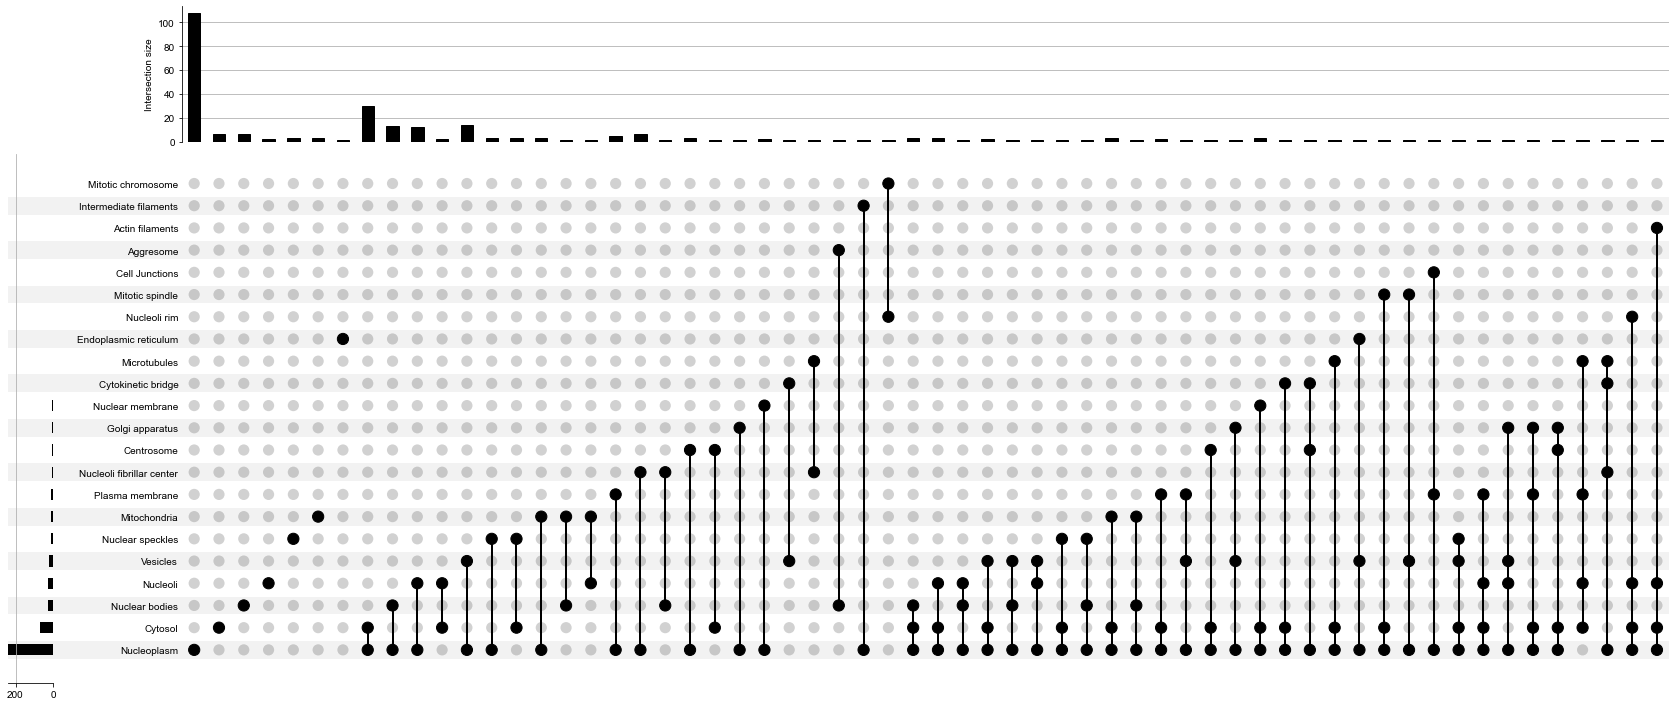

In [3]:
loc.columns = [c[3:] for c in loc.columns]
cols = list(loc.columns[loc.loc[loc.index.isin(tf_genes), :].any()])
upsetplot.plot(loc.loc[loc.index.isin(tf_genes), cols]
                  .groupby(cols).size())
loc.columns = ["in_" + c for c in loc.columns]
plt.savefig('../figures/subcellular-localization_gencode_UpSet-plot.pdf',
            bbox_inches='tight')

In [4]:
n_iso_cytosol = [len(tf.isoforms) for tf in tfs.values() if tf.ensembl_gene_id in tfs_cytosol]
n_iso_no_cytosol = [len(tf.isoforms) for tf in tfs.values() if tf.ensembl_gene_id in tfs_no_cytosol]
print(stats.mannwhitneyu(n_iso_cytosol, n_iso_no_cytosol))
print(np.mean(n_iso_cytosol), np.mean(n_iso_no_cytosol))

MannwhitneyuResult(statistic=7181.5, pvalue=0.9603645419231225)
3.857142857142857 3.9271844660194173


In [5]:

def has_DBD_loss_isoform(tf):
    if len(tf.isoforms) == 1:
        return np.nan
    df = tf.aa_feature_disruption(tf.reference_isoform.name)
    if df.shape[0] == 0:
        return np.nan
    df = df.loc[df['accession'].isin(load_dbd_accessions())]
    if df.shape[0] == 0:
        return np.nan
    return df.loc[:, ['deletion', 'insertion', 'frameshift']].sum().sum() > 0
    

has_DBD_loss_isoform(tfs['ATF2'])

True

In [6]:
# DBD loss isoforms with cytosol location
stats.fisher_exact(
    [[
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol)

],
                    [
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol)
                    ]])


SignificanceResult(statistic=0.7136030582988213, pvalue=0.2952635779880956)

In [7]:
   [[
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol)

],
                    [
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol)
                    ]]

[[20, 43], [73, 112]]

In [8]:
cloned_tf_genes = {tf.ensembl_gene_id for tf in load_annotated_TFiso1_collection().values() if len(tf.isoforms) > 1}
print(len(cloned_tf_genes), 'TF genes with at least 2 cloned isoforms')
print(sum(g in loc.index for g in cloned_tf_genes), 
    'have localization data')
print(loc.loc[loc.index.isin(cloned_tf_genes), 'in_Cytosol'].sum(),
      'observed in cytosol')

reading from cache
298 TF genes with at least 2 cloned isoforms
267 have localization data
67 observed in cytosol


In [9]:
len(cloned_tf_genes)

298

In [14]:
# difference in activation, PPIs and PDIs for
# TFs in cytosol
from data_loading import *

y2h = load_isoform_and_paralog_y2h_data()
y2h = y2h.loc[y2h['category'].isin(['tf_isoform_ppis',
                                    'tf_paralog_ppis',
                                    'non_paralog_control',
                                    'paralog_with_PDI']),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
df = load_ref_vs_alt_isoforms_table()

In [12]:
ref_isos = {tf.cloned_reference_isoform.clone_acc for tf in load_annotated_TFiso1_collection().values()}

reading from cache


In [17]:
def in_cytosol(ensembl_gene_id):
    if ensembl_gene_id in tfs_cytosol:
        return True
    elif ensembl_gene_id in tfs_no_cytosol:
        return False
    else:
        return np.nan

df['in_cytosol'] = df['Ensembl_gene_ID'].apply(in_cytosol)

In [18]:
df.loc[df['PPI_jaccard'].notnull(), :].head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,in_cytosol
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.0,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.0,True,2.153413,2.656826,0.503414,False
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.0,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,False
5,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,True,602,626,16,16,False,True,False,False,False,False,False,False,0.0,0.0,False,90.9,2.0,0.0,2.0,2.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.436213,-0.241994,-0.678207,False
6,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,True,602,607,16,16,True,False,False,False,False,False,False,False,0.0,0.0,False,98.4,2.0,0.0,2.0,2.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,False,0.436213,0.248480,-0.187733,False
7,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|4/7|08F09,ENST00000361548,ENST00000356046,False,False,True,602,556,16,15,True,False,False,False,True,False,False,False,0.0,0.0,False,92.0,2.0,1.0,2.0,2.0,1.0,1.0,0.50,retains all,loses all,retains all,NaN,NaN,NaN,79.0,NaN,NaN,NaN,NaN,NaN,False,0.436213,0.041061,-0.395152,False


In [23]:
df['n_positive_PPI_min'] = df[['n_positive_PPI_ref', 'n_positive_PPI_alt']].min(axis=1)

KstestResult(statistic=0.22413793103448276, pvalue=0.17893880665922898, statistic_location=0.8888888888888888, statistic_sign=-1)

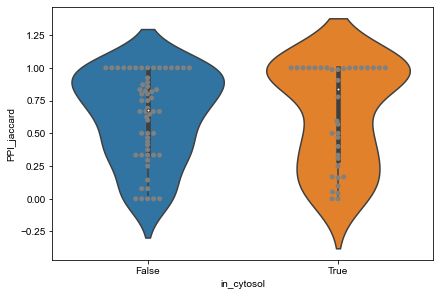

In [26]:
import seaborn as sns
from scipy import stats
# TODO: at least 2 PPIs and at least some interactions each???
# TODO: print number of genes
data = df.loc[df['PPI_jaccard'].notnull() & (df['n_positive_PPI_min'] >= 1), :]
sns.swarmplot(data=data,
              x='in_cytosol',
              y='PPI_jaccard',
              color='grey')
sns.violinplot(data=data,
              x='in_cytosol',
              y='PPI_jaccard')

stats.ks_2samp(data.loc[data['in_cytosol'] == True, 'PPI_jaccard'].values,
               data.loc[data['in_cytosol'] == False, 'PPI_jaccard'].values
)

KstestResult(statistic=0.11515151515151516, pvalue=0.992289383864595, statistic_location=0.625, statistic_sign=-1)

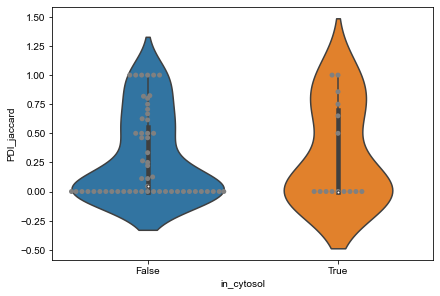

In [28]:
data = df.loc[df['PDI_jaccard'].notnull(), :]
sns.swarmplot(data=data,
              x='in_cytosol',
              y='PDI_jaccard',
              color='grey')
sns.violinplot(data=data,
              x='in_cytosol',
              y='PDI_jaccard')

stats.ks_2samp(data.loc[data['in_cytosol'] == True, 'PDI_jaccard'].values,
               data.loc[data['in_cytosol'] == False, 'PDI_jaccard'].values)

In [30]:
df['activation_abs_fold_change'] = df['activation_fold_change_log2'].abs()

Ttest_indResult(statistic=-1.6998314632102665, pvalue=0.09022026391113029)

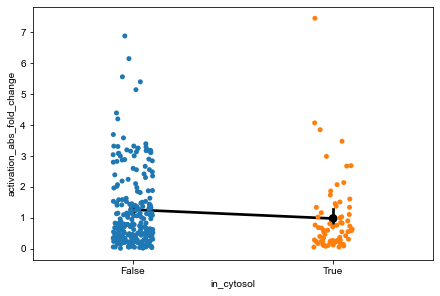

In [31]:
data = df.loc[df['activation_abs_fold_change'].notnull(), :]

sns.stripplot(data=data,
              x='in_cytosol',
              y='activation_abs_fold_change')
sns.pointplot(data=data,
              x='in_cytosol',
              y='activation_abs_fold_change',
              color='black')

stats.ttest_ind(data.loc[data['in_cytosol'] == True, 'activation_abs_fold_change'].values,
               data.loc[data['in_cytosol'] == False, 'activation_abs_fold_change'].values)

<AxesSubplot: xlabel='in_cytosol', ylabel='activation_fold_change_log2'>

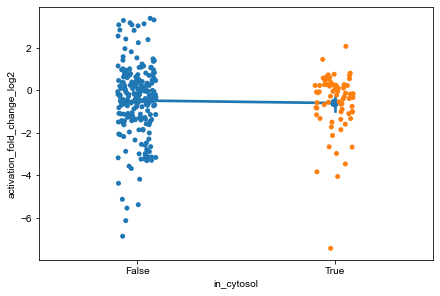

In [32]:
sns.stripplot(data=df,
              x='in_cytosol',
              y='activation_fold_change_log2')
sns.pointplot(data=df,
              x='in_cytosol',
              y='activation_fold_change_log2')

In [33]:
from collections import Counter
Counter(tf.chrom for tf in tfs.values() if tf.tf_family == 'Nuclear receptor')

Counter({'chr1': 4,
         'chr2': 1,
         'chr3': 3,
         'chr5': 1,
         'chr6': 2,
         'chr9': 1,
         'chr11': 2,
         'chr12': 3,
         'chr14': 1,
         'chr15': 2,
         'chr17': 2,
         'chr20': 1})

In [34]:
tab = [[sum(tf.ensembl_gene_id in tfs_cytosol for tf in tfs.values() 
    if tf.tf_family == 'Nuclear receptor'),
sum(tf.ensembl_gene_id in tfs_no_cytosol for tf in tfs.values() 
    if tf.tf_family == 'Nuclear receptor')],
    [sum(tf.ensembl_gene_id in tfs_cytosol for tf in tfs.values() 
    if tf.tf_family != 'Nuclear receptor'),
sum(tf.ensembl_gene_id in tfs_no_cytosol for tf in tfs.values() 
    if tf.tf_family != 'Nuclear receptor')],]
print(tab)
print(stats.fisher_exact(tab))

[[7, 14], [63, 192]]
SignificanceResult(statistic=1.5238095238095237, pvalue=0.43407649911455115)
